# Exploring StackOverflow open dataset with BigQuery

In a search for interesting data science problems.

DataQubit

2019

### Possible ideas to explore:

* #### Understanding StackOverflow users through the data:
    There are 9737247 unique users in the `users` table. They are all different in many ways, but similar in some ways. Can data mining help in determining who is a typical user of the service, in answering more complex questions such as - which users will likely be able to answer a particular question.  Another complex question is - can we rank users according to their skills and find top ranked users matching the given job description, for example, a job post from Indeed.com.  

In [2]:
import numpy as np
import pandas as pd
import bq_helper
from bq_helper import BigQueryHelper
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

Using Kaggle's public dataset BigQuery integration.


StackOverflow BigQuery dataset consists of the following tables: 

In [3]:
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")
bq_assistant.list_tables()

Using Kaggle's public dataset BigQuery integration.


['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

Today we will explore the posts_questions table:

In [9]:
bq_assistant.head("posts_questions", num_rows=5)

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,post_type_id,score,tags,view_count
0,49109733,"Hide ""Look up"" bubble on input fields - IOS Sa...","<p>How to hide ""Look up"" bubble when the user...",NaN,0,1,None,2018-03-05 11:44:01.730000+00:00,None,2018-03-05 11:44:01.730000+00:00,NaT,,NaN,,2169274.0,1,0,javascript|html|safari,27
1,44662632,Can I use links in chrome extensions?,<p>I have manifest.json containing this:</p>\n...,NaN,0,2,None,2017-06-20 20:42:15.823000+00:00,None,2017-06-20 20:42:15.823000+00:00,NaT,,NaN,user8190318,NaN,1,0,javascript|google-chrome-extension,20
2,45338606,JQuery click 1 does nothing,<p>I have a feeling there is something wrong w...,45339322.0,1,2,None,2017-07-26 22:42:44.247000+00:00,None,2017-07-27 00:09:08.560000+00:00,NaT,,NaN,,8100494.0,1,2,javascript|ajax|for-loop,56
3,50876533,Specify --json in webpack config instead of co...,<p>I'm using Webpack 4 via webpack-stream / gu...,50880737.0,1,1,None,2018-06-15 13:23:22.823000+00:00,None,2018-06-20 14:05:45.530000+00:00,NaT,,NaN,,684776.0,1,0,webpack|gulp,66
4,13658739,Java - key event listener,<p>Is it possible to bind an action listener f...,13659220.0,2,8,None,2012-12-01 10:59:07.213000+00:00,None,2012-12-01 11:57:37.083000+00:00,2012-12-01 11:07:10.033000+00:00,,418556.0,,1184717.0,1,0,java|command-line-interface,2065


In [10]:
bq_assistant.head("users", num_rows=5)

,id,display_name,about_me,age,creation_date,last_access_date,location,reputation,up_votes,down_votes,views,profile_image_url,website_url
0,1476352,Alexandre Magno Teles Zimerer,<p>Alexandre Magno is a software engineer at G...,,2012-06-23 04:38:23.753000+00:00,2018-12-01 14:09:53.237000+00:00,Rio de Janeiro,61,629,0,24,,http://blog.alexandremagno.net
1,2756832,Kandy,,,2013-09-07 11:04:10.827000+00:00,2018-11-30 12:18:11.977000+00:00,"Patna, Bihar, India",122,20,0,29,https://www.gravatar.com/avatar/c13404e96c0f0b...,
2,2470755,C.Colden,,,2013-06-10 11:39:35.650000+00:00,2018-12-01 21:36:14.527000+00:00,,463,45,5,95,,
3,330842,Xav,,,2010-05-02 14:11:39.690000+00:00,2018-11-30 14:01:19.913000+00:00,,192,49,13,18,,
4,3357481,Mutating Algorithm,,,2014-02-26 19:33:16.937000+00:00,2018-11-29 15:42:00.937000+00:00,,798,94,5,246,https://graph.facebook.com/100006348219116/pic...,


In [11]:
query1 = """SELECT COUNT(id) AS num_users
FROM
  `bigquery-public-data.stackoverflow.users`;
        """

In [12]:
stackOverflow.estimate_query_size(query1)

0.07254814356565475

In [14]:
num_users = stackOverflow.query_to_pandas_safe(query1, max_gb_scanned=1.5)

In [15]:
num_users # 9737247 users

,num_users
0,9737247


In [ ]:
num_users

In [ ]:
some_tags = stackOverflow.query_to_pandas_safe(query_some_tags, max_gb_scanned=1.5)

In [ ]:
query_latest_date = """
SELECT 
    MIN(creation_date) AS earliest_creation_date,
    MAX(creation_date) AS latest_creation_date
FROM 
    `bigquery-public-data.stackoverflow.stackoverflow_posts`
"""
df_latest_date = stackOverflow.query_to_pandas_safe(query_latest_date)

In [ ]:
df_latest_date

In [ ]:
query_latest_date_qposts = """
SELECT 
    MIN(creation_date) AS earliest_creation_date,
    MAX(creation_date) AS latest_creation_date
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
"""
df_latest_date_qposts = stackOverflow.query_to_pandas_safe(query_latest_date_qposts)

In [ ]:
df_latest_date_qposts

## Python and R Questions

How stats of questions related to these two common languages differ?

In [62]:
# for future study we may need the folllowing columns
cols_of_interest = ['id', 'title', 'accepted_answer_id', 'answer_count',
       'comment_count', 'creation_date', 'favorite_count', 'last_activity_date', 
       'last_edit_date', 'owner_user_id', 'post_type_id', 'score', 'tags',
       'view_count']

In [54]:
# SQL query to extract Python & R questions
query_python_posts = """
SELECT %s,
    REGEXP_CONTAINS(tags, r'python') AS is_python,
    REGEXP_CONTAINS(tags, r'%s') AS is_r
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
WHERE
    REGEXP_CONTAINS(tags, r'python') OR
    REGEXP_CONTAINS(tags, r'%s')
""" %(','.join(cols_of_interest), r'\br\b', r'\br\b')
# check the size of this query
stackOverflow.estimate_query_size(query_python_posts)

2.5707095079123974

In [55]:
# make sure the query looks fine
print(query_python_posts)


SELECT id,title,accepted_answer_id,answer_count,comment_count,creation_date,favorite_count,last_activity_date,last_edit_date,owner_user_id,post_type_id,score,tags,view_count,
    REGEXP_CONTAINS(tags, r'python') AS is_python,
    REGEXP_CONTAINS(tags, r'\br\b') AS is_r
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
WHERE
    REGEXP_CONTAINS(tags, r'python') OR
    REGEXP_CONTAINS(tags, r'\br\b')



In [56]:
# save results to a dataframe
df_python_r = stackOverflow.query_to_pandas_safe(query_python_posts, max_gb_scanned=3.0)

In [49]:
df_python_r.head()

,id,title,accepted_answer_id,answer_count,comment_count,creation_date,favorite_count,last_activity_date,last_edit_date,owner_user_id,post_type_id,score,tags,view_count,is_python,is_r
0,42871315,Reverse keys with values list comprehension al...,NaN,1,11,2017-03-18 06:31:52.700000+00:00,NaN,2017-03-18 07:06:13.593000+00:00,2017-03-18 06:39:02.583000+00:00,7147191.0,1,0,python|dictionary|collections|list-comprehension,65,True,False
1,34607305,Why do brackets catch the last character inste...,34607334.0,2,17,2016-01-05 08:37:09.537000+00:00,NaN,2016-01-05 19:49:55.353000+00:00,2016-01-05 09:36:36.640000+00:00,5299236.0,1,-2,python|regex,72,True,False
2,25574381,Using Python's xlrd module to find column with...,NaN,2,18,2014-08-29 18:43:42.697000+00:00,NaN,2014-08-29 22:04:08.643000+00:00,2014-08-29 20:37:37.037000+00:00,3991149.0,1,2,python|excel|date|datetime|xlrd,953,True,False
3,27878137,How to check if the number can be represented ...,NaN,3,14,2015-01-10 15:58:52.910000+00:00,3.0,2016-09-20 00:25:00.550000+00:00,2015-01-10 16:40:16.793000+00:00,3785289.0,1,5,python|algorithm|primes|number-theory|nth-root,1353,True,False
4,31089228,pulling numbers out of text,NaN,1,11,2015-06-27 13:16:12.953000+00:00,NaN,2015-06-27 14:48:29.347000+00:00,2015-06-27 13:39:54.393000+00:00,5056072.0,1,-4,python|file|text|calculator,50,True,False


### How many Python/R questions there are in total?

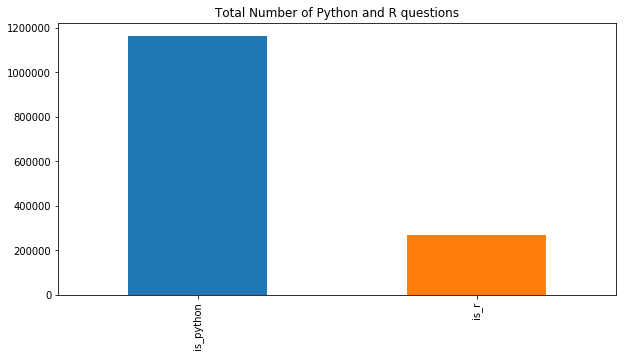

In [65]:
df_python_r[['is_python', 'is_r']].sum().plot(kind='bar', figsize=(10, 5),
                                             title='Total Number of Python and R questions')

### How many questions contain both Python and R in the tags?

In [67]:
(df_python_r.is_python & df_python_r.is_r).sum()

3324

### How two numbers grow with time? 

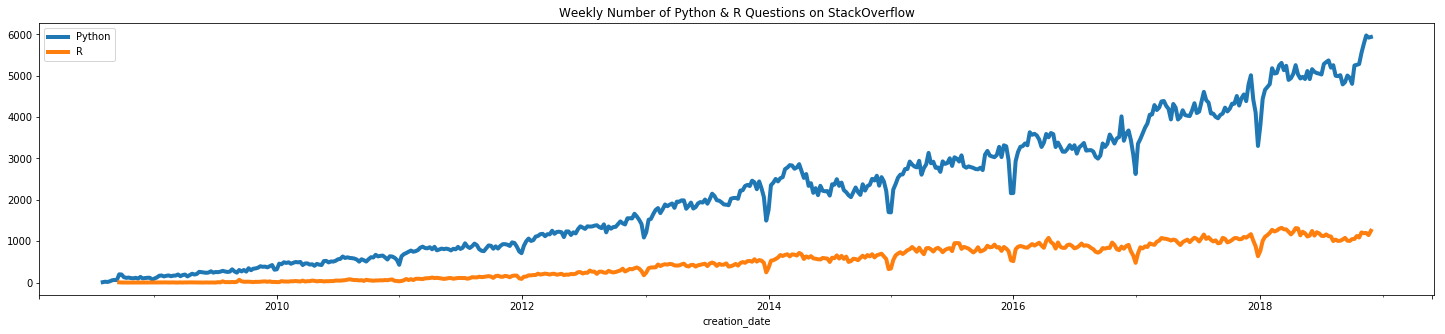

In [61]:
df_python_r[df_python_r.is_python].resample('1W', on='creation_date').id.count().plot(figsize=(25, 5), label='Python', legend=True,
                                                                                     linewidth=4)
df_python_r[df_python_r.is_r].resample('1W', on='creation_date').id.count().plot(figsize=(25, 5), label='R', legend=True,
                                                                                linewidth=4,
                                                                                title='Weekly Number of Python & R Questions on StackOverflow')

### On which weekdays users typically ask their questions ?

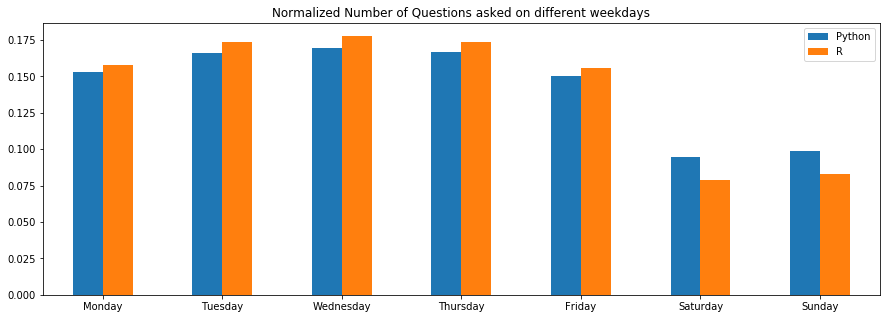

In [99]:
pd.DataFrame({'Python': df_python_r[df_python_r.is_python].creation_date.dt.weekday.value_counts(sort=False, normalize=True).values,
              'R': df_python_r[df_python_r.is_r].creation_date.dt.weekday.value_counts(sort=False, normalize=True).values},
              index=['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']).plot(
              kind='bar', figsize=(15, 5), rot=0, title='Normalized Number of Questions asked on different weekdays')

Note that Python questions are asked more often during the weekends than the R questions. Is it because on weekends people tend to work more on their side projects (and Python is more suitable to that)? It might be possible to determine this by looking at the typical questions asked on those days.  

### Which hours of day are more common for asking Python & R questions

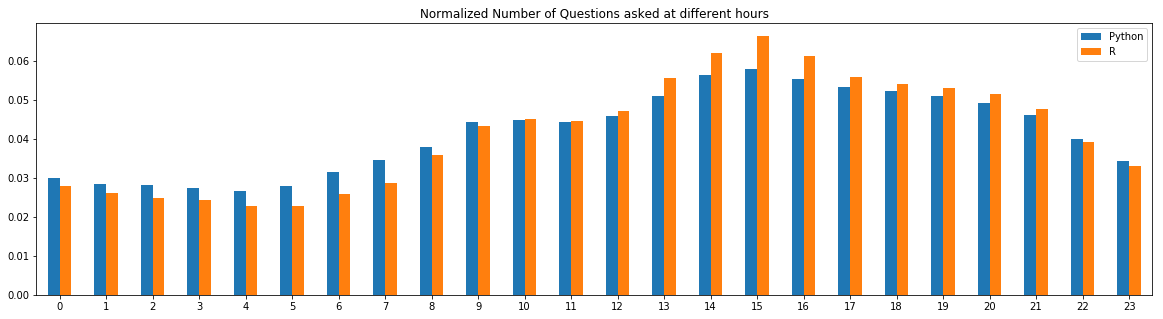

In [106]:
pd.DataFrame({'Python': df_python_r[df_python_r.is_python].creation_date.dt.hour.value_counts(sort=False, normalize=True),
              'R': df_python_r[df_python_r.is_r].creation_date.dt.hour.value_counts(sort=False, normalize=True)},
              ).plot(
              kind='bar', figsize=(20, 5), rot=0, title='Normalized Number of Questions asked at different hours')

It is interesting that Python questions are asked more over the night/morning hours, and R questions are asked more in daytime hours!

### Let's take a look at different distributions for question parameters

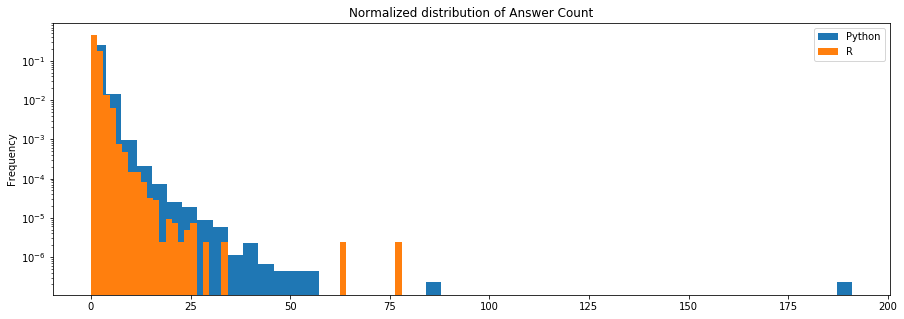

In [113]:
df_python_r[df_python_r.is_python].answer_count.plot(kind='hist', figsize=(15, 5), bins=50, logy=True, density=True,
                                                    label='Python', legend=True)
df_python_r[df_python_r.is_r].answer_count.plot(kind='hist', figsize=(15, 5), bins=50, logy=True, density=True,
                                                label='R', legend=True, title='Normalized distribution of Answer Count')

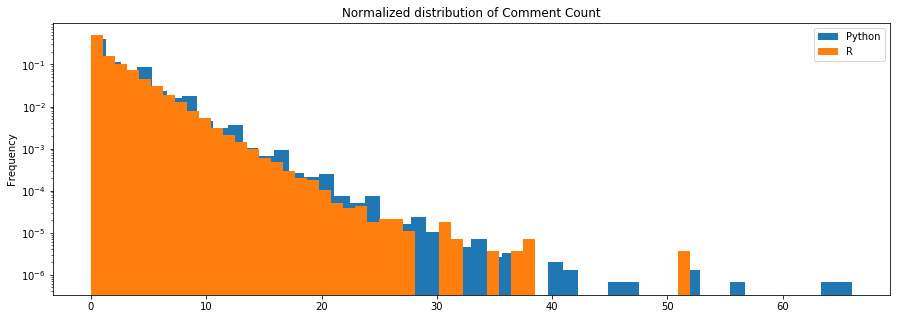

In [114]:
df_python_r[df_python_r.is_python].comment_count.plot(kind='hist', figsize=(15, 5), bins=50, logy=True, density=True,
                                                    label='Python', legend=True)
df_python_r[df_python_r.is_r].comment_count.plot(kind='hist', figsize=(15, 5), bins=50, logy=True, density=True,
                                                label='R', legend=True, title='Normalized distribution of Comment Count')

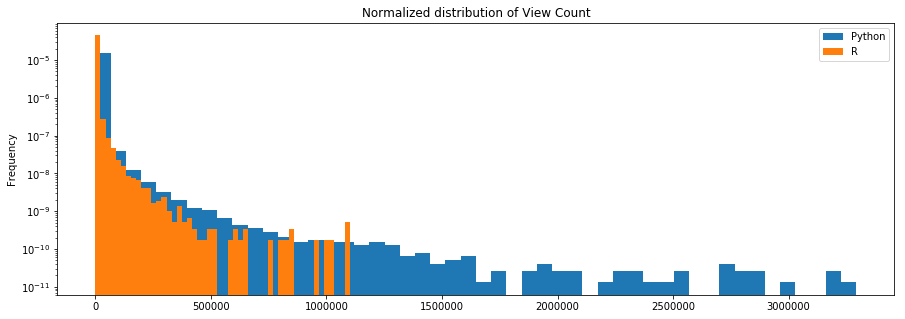

In [115]:
df_python_r[df_python_r.is_python].view_count.plot(kind='hist', figsize=(15, 5), bins=50, logy=True, density=True,
                                                    label='Python', legend=True)
df_python_r[df_python_r.is_r].view_count.plot(kind='hist', figsize=(15, 5), bins=50, logy=True, density=True,
                                                label='R', legend=True, title='Normalized distribution of View Count')

### To be continued...